In [5]:
import pandas as pd
import random

def create_random_text_file(csv_file, num_values, output_file):
    df = pd.read_csv(csv_file)

    symbol_values = df['Symbol'].tolist()

    random_indices = random.sample(range(len(symbol_values)), min(num_values, len(symbol_values)))

    random_symbols = [symbol_values[i] for i in random_indices]

    with open(output_file, 'w') as file:
        #file.write("Ticker") 
        for symbol in random_symbols:
            file.write(f"{symbol}\n")

    print(f"Written to {output_file}")

create_random_text_file('RAW_stocknames.csv', 50, 'ticker.csv')

Written to ticker.csv


USB^P: No data found, symbol may be delisted
AITRR: Period '1mo' is invalid, must be one of ['1d', '5d']
NNAGR: Period '1mo' is invalid, must be one of ['1d', '5d']
OAK^A: No data found, symbol may be delisted


Valid Ticker Symbols:
POET
RNG
NKE
CWAN
RLI
FTCI
VRSN
SYBT
TCMD
APM
DCOMP
TSVT
FNWD
IBKR
ELS
ARVN
CSWI
NRP
XXII
SFM
FNF
CTLP
PTON
MCBS
HUGE
ZOM
PR
KVYO
BXP
EIC
BURL
DSAQ
SOVO
MXE
EG
SPIR
ITOS
NYMTN
HYT
GRNQ
CVV
BTOG
MGOL
MARA
BAER
SSYS

Close Week Data:
                            POET         RNG         NKE       CWAN  \
Date                                                                  
2021-01-10 00:00:00-05:00   6.30  387.950012  141.879761        NaN   
2021-01-17 00:00:00-05:00   6.30  372.929993  136.421722        NaN   
2021-01-24 00:00:00-05:00   7.50  384.519989  135.093552        NaN   
2021-01-31 00:00:00-05:00   8.40  372.920013  129.509506        NaN   
2021-02-07 00:00:00-05:00  10.80  407.170013  140.677612        NaN   
...                          ...         ...         ...        ...   
2023-12-03 00:00:00-05:00   1.14   30.750000  113.480003  19.760000   
2023-12-10 00:00:00-05:00   1.05   34.110001  115.910004  19.250000   
2023-12-17 00:00:00-05:00   0.80   3

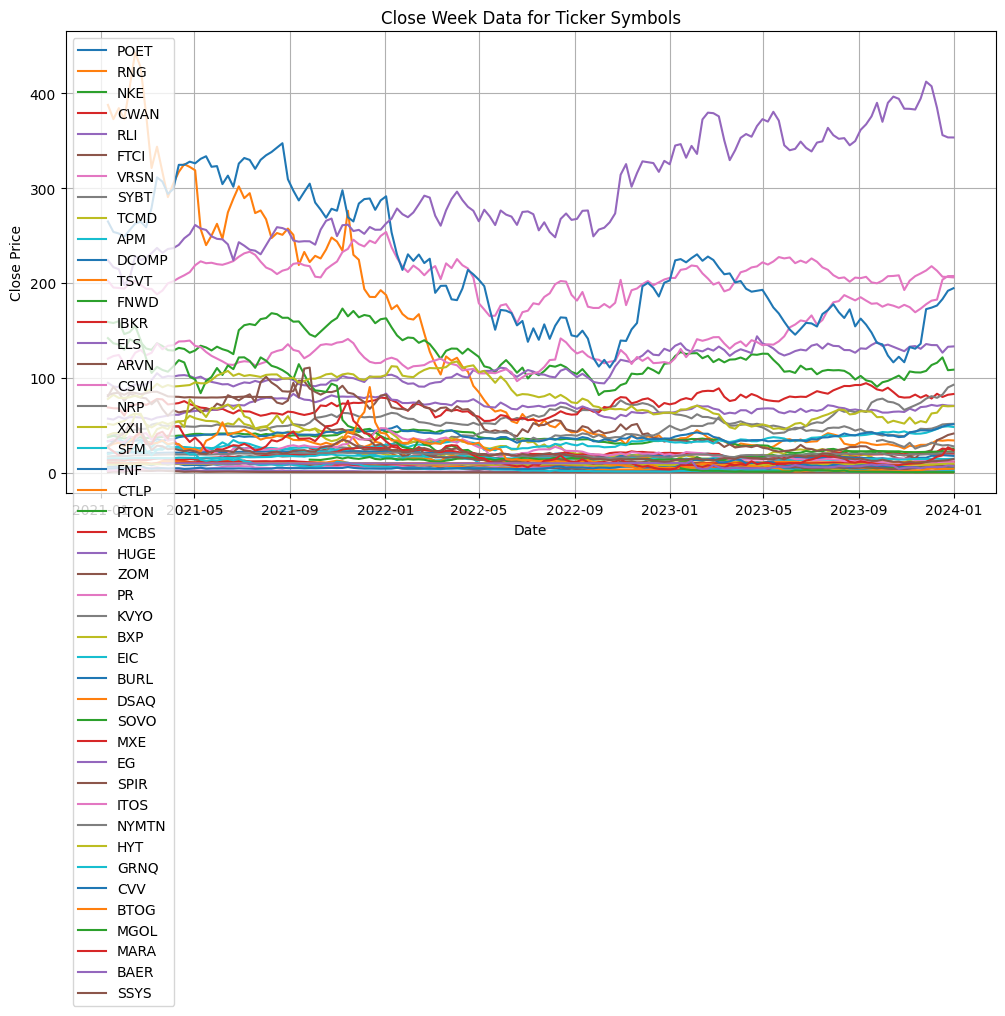

In [6]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def get_ticker_symbols():
    ticker_symbols = pd.read_csv("ticker.csv", header=None)[0].tolist()
    return ticker_symbols

def validate_ticker_symbol(symbol):
    ticker = yf.Ticker(symbol)
    data = ticker.history()
    
    if data.empty:
        return False
    else:
        return True

def get_close_weeks(start_date, end_date):
    ticker_symbols = get_ticker_symbols()
    valid_ticker_symbols = []
    close_week_data = pd.DataFrame()
    
    for symbol in ticker_symbols:
        if validate_ticker_symbol(symbol):
            ticker = yf.Ticker(symbol)
            data = ticker.history(start=start_date, end=end_date)
            
            if not data.empty:
                weekly_data = data.resample('W').last().dropna()
                
                if not weekly_data.empty:
                    valid_ticker_symbols.append(symbol)
                    close_week_data[symbol] = weekly_data['Close']
    
    return valid_ticker_symbols, close_week_data

start_date = '2021-01-01'
end_date = '2024-01-01'

valid_symbols, close_week_data = get_close_weeks(start_date, end_date)

close_week_data.to_csv("net_changes.csv")

print("Valid Ticker Symbols:")
for symbol in valid_symbols:
    print(symbol)

print("\nClose Week Data:")
print(close_week_data)
print("\nClose week data saved to 'net_changes.csv'")

# Plotting the data
plt.figure(figsize=(12, 6))
for symbol in close_week_data.columns:
    plt.plot(close_week_data.index, close_week_data[symbol], label=symbol)

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Week Data for Ticker Symbols")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\clear\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Tickers in each Cluster:
Cluster 0: 
Cluster 1: APM, DCOMP, TSVT, FNWD, IBKR, ELS, ARVN, CSWI, NRP, XXII, SFM, FNF, CTLP, PTON, MCBS, HUGE, ZOM, PR, KVYO, BXP, EIC
Cluster 2: BAER, SSYS
Cluster 3: 
Cluster 4: 
Cluster 5: 
Cluster 6: POET, RNG, NKE, CWAN, RLI, FTCI, VRSN, SYBT, TCMD
Cluster 7: ITOS, NYMTN, HYT, GRNQ, CVV, BTOG, MGOL, MARA
Cluster 8: 
Cluster 9: BURL, DSAQ, SOVO, MXE, EG, SPIR


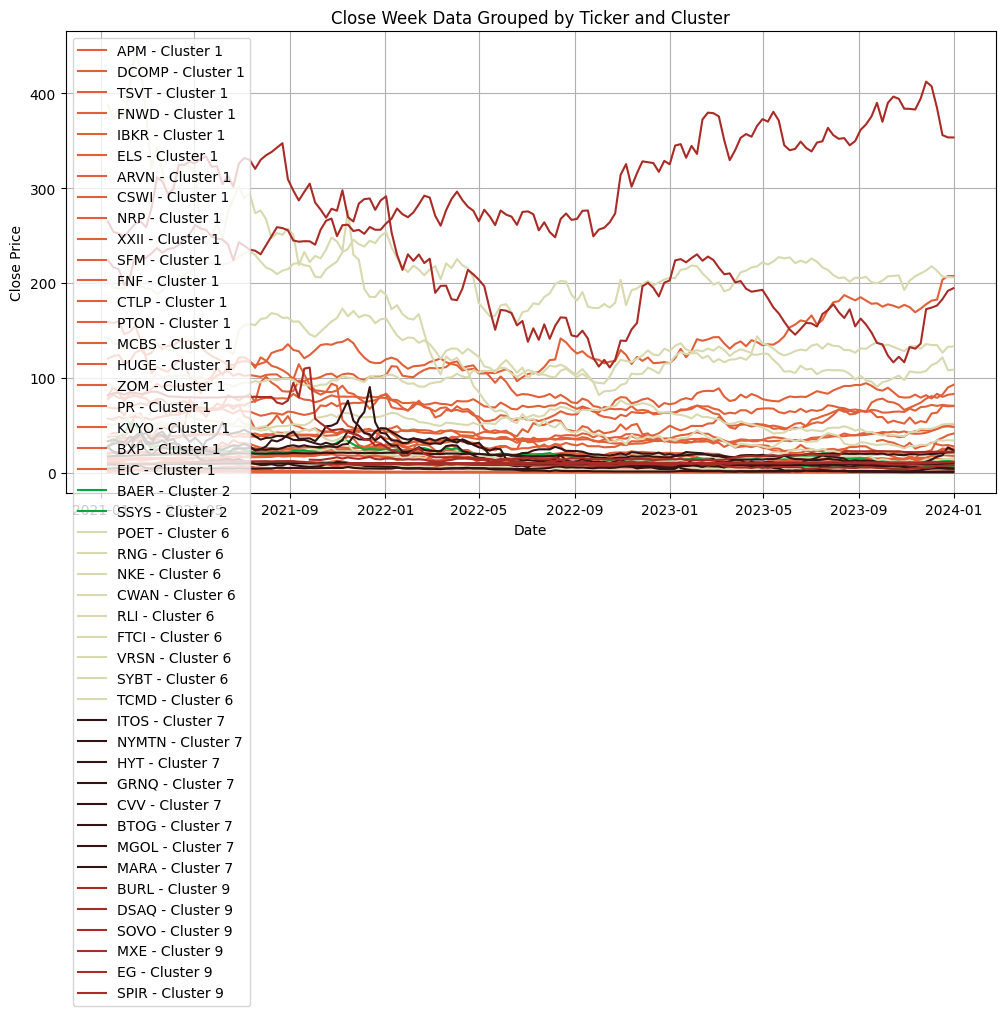

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
import joblib

close_week_data = pd.read_csv("net_changes.csv", index_col=0, parse_dates=True)

# Normalize the data using Min-Max normalization
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(close_week_data.values)

# Remove outliers using standard deviation
mean = np.mean(normalized_data, axis=0)
std = np.std(normalized_data, axis=0)
threshold = 3

filtered_data = normalized_data[~((normalized_data - mean) > threshold * std).any(axis=1)]

# Remove data with zero variance
variances = np.var(filtered_data, axis=0)
nonzero_variance_indices = np.where(variances != 0)[0]
filtered_data = filtered_data[:, nonzero_variance_indices]

# Handle NaN values
filtered_data = np.nan_to_num(filtered_data)

k = 10 # Number of clusters 
model = KMeans(n_clusters=k, random_state=42, max_iter=1000, tol=1e-4)
cluster_labels = model.fit_predict(filtered_data)

# Save the trained model using joblib
joblib.dump(model, 'kmeans_model.joblib')

ticker_clusters = {i: [] for i in range(k)}

for i, ticker in enumerate(close_week_data.columns):
    ticker_clusters[cluster_labels[i]].append(ticker)

print("Tickers in each Cluster:")
for cluster, tickers in ticker_clusters.items():
    print(f"Cluster {cluster}: {', '.join(tickers)}")

# Generate random colors for each cluster (NOT my code. Created using chatgpt)
random.seed(42)
cluster_colors = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for i in range(k)]

# Plotting the tickers in each cluster
plt.figure(figsize=(12, 6))
for cluster, tickers in ticker_clusters.items():
    for ticker in tickers:
        plt.plot(close_week_data.index, close_week_data[ticker], label=f"{ticker} - Cluster {cluster}", color=cluster_colors[cluster])

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Week Data Grouped by Ticker and Cluster")
plt.legend()
plt.grid(True)
plt.show()